# Factors that affect Crime Rate in Major Cities

#### IS590 Program Analysis Final Project 
###### Team member: Shuang Ke, Yiwen Wang, Xinrong Li

Chicago is the most populous city in Illinois, it is famous for its fancy skyscrapers, and is also notorious for its high crime rates. The city's overall crime rate, especially the violent crime rate, is higher than the US average. Finding the causes of crime could be the most effective process to reduce the crime rate.
 
Additional to Chicago, we would also analyze other major cities such as Los Angeles, New York City. We would analyze the relationship between crime and weather factors(temperature, humidity etc.), as well as the relationship between crime and air pollution. By doing this analysis, we can compare and determine which factors have greater impact on each city. 

To find out if there is any association bewteen weather and Crime, we come up with several hypothesis as following:



## Hypothesis 
- Temperature could be one of the factors that affect crimes in major cities. The frequency of crime is relatively high in warm seasons and low in cold seasons. 


- Air pollution could be one of the factors that affect crime rate. Server air pollution can trigger physical discomfort which could lead to antisocial behavior and induce aggression, thus increasing the crime rate.


- Humidity might have different degrees of influence on different types of crime. It might has greater impact on sexual crime.






Describe our dataset 

### Subtitle 

describe the method we use, how we analyze 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import add
from sklearn import preprocessing
from statsmodels.formula.api import ols
%matplotlib inline


from datetime import datetime

In [2]:
import FUNC

In [3]:
def read_indata(path):
    '''
    This function is used when given the path read in data 

    :param path: a string of path saved the dataset
    :return: pandas datarame
    '''
    data = pd.read_csv(path)
    return data

In [4]:
def generate_year_month_day(df, colname):
    '''
    This function generate three new columns, which are year, month and day based on the variable 
    datetime
    
    :param df: dataframe we want to add column year and month
    :param colname: a stirng column name in the dataframe saved the dateandtime
    :return: dataframe after adding the column
    >>> raw_data = {'name': ['Willard Morris', 'Al Jennings', 'Omar Mullins', 'Spencer McDaniel'],'birth_date': ['01-02-1996', '08-05-1997', '04-28-1996', '12-16-1995']}
    >>> df = pd.DataFrame(raw_data, index = ['Willard Morris', 'Al Jennings', 'Omar Mullins', 'Spencer McDaniel'])
    >>> df_after=generate_year_month_day(df,'birth_date')
    >>> df['day'].sum()
    51
    '''
    df['year'] = pd.DatetimeIndex(df[colname]).year
    df['month'] = pd.DatetimeIndex(df[colname]).month
    df['day'] = pd.DatetimeIndex(df[colname]).day
    return df

In [5]:
def get_city_weather(cityname, df_list, stringlist):
    """
    Extract the specific city's weather, including temperature, humidity, wind speed, from the 
    weather dataset 
    
    :param cityname: a string of cityname, like "Chicago"
    :param df_list: a list of dataframe 
    :param stringlist: a list of the name of these dataframe
    :return: a new list of dataframe, with some information updated  
    
    """
    new_df_list = []
    for i in range(len(stringlist)):
        citydf = df_list[i][(df_list[i].year>=2012) & (df_list[i].year<2018)].copy(deep=True)
        citydf = citydf[['year', 'month', 'day', cityname]]
        citydf[['year', 'month', 'day']] = citydf[['year', 'month', 'day']].astype(int)
        citydf = pd.DataFrame(citydf.groupby(['year', 'month', 'day']).mean())
        citydf = citydf.reset_index()
        citydf = citydf.rename(columns={cityname: stringlist[i]})

        new_df_list.append(citydf)
    return new_df_list




In [6]:

def merge_dataframe(df1, df2, mergeby):
    
    """
    Given two dataframe and merged by which column/columns, we are able to get
    the left join dataframe
    
    :param df1: a dataframe 
    :param df2: a dataframe 
    :param mergeby: column names referred to merge om 
    :return: merged data
    """

    merged_data = pd.merge(df1, df2, on=mergeby, how='left')

    return merged_data


In [7]:
def mergeall_weather(new_df_list, mergeby):
    """
    This function is used to merge all the updated weather dataframe 
    
    :param new_df_list: updated list of weather dataframe from former step 
    :param mergeby: column named referred to merge om 
    :return: new dataframe merged all weather 
    """
    
    weather_all = new_df_list[0]
    for i in range(len(new_df_list) - 1):
        weather_all = merge_dataframe(weather_all, new_df_list[i+1], mergeby)
    return weather_all


In [8]:

def get_city(cityname, citycrime, weather_all):
    '''
    This function is used to get the merged crime data and weather data of the pointed city

    :param cityname: a string of the name of the city
    :param citycrime: the crime data of this city 
    :param weather_all: new dataframe merged all weather 
    :return: new dataframe 
    '''

    
    city_weather = weather_all[['year', 'month','day', cityname,'indextype']].copy(deep = True)
    citycrime_per_month = citycrime.groupby(['year', 'month', 'day']).size()
    citycrime_per_month = pd.DataFrame(citycrime_per_month.reset_index())
    citycrime_per_month = citycrime_per_month.rename(columns = {0:'Count'})
    citycrime_per_month[['year', 'month', 'day']] = citycrime_per_month[['year', 'month', 'day']].astype(int)

    city_weather[['year', 'month', 'day']] = city_weather[['year', 'month', 'day']].astype(int)

    crime_weather = pd.merge(city_weather[['year', 'month', 'day',cityname, 'indextype']], citycrime_per_month,
                             on=['year', 'month'], how='left')

    crime_weather = crime_weather[(crime_weather.year >= 2012) & (crime_weather.year < 2018)]
    crime_weather = crime_weather.rename(columns={cityname: 'indexvalue'})

    return crime_weather

In [9]:
def vectorize_humidity(df):
    """
    To vectorize the humidity 
    
    :param df: dataframe containing Humidity
    :return: a value after vectorize the humidity
    """
    if df['Humiditiy'] <= 0.45:
        val = 'Low'
    elif df['Humiditiy'] <= 0.65:
        val = 'Normal'
    elif df['Humiditiy'] > 0.65:
        val = 'High'
    return val


In [10]:
def vectorize_temperature(df):
    """
    To vectorize the Temperature 
    
    :param df: dataframe containing temperature
    :return: a value after vectorize
    """
    
    if df['Temperature'] <= 5:
        val = '0-5'
    elif df['Temperature'] <= 10:
        val = '5-10'
    elif df['Temperature'] <= 15:
        val = '10-15'
    elif df['Temperature'] <= 20:
        val = '15-20'
    elif df['Temperature'] <= 25:
        val = '20-25'
    elif df['Temperature'] <= 30:
        val = '25-30'
    elif df['Temperature'] > 30:
        val = '>30'
    return val


In [11]:
def normalize_humidity(df, colname):
    """
    This function is used to normalized the pointed column

    :param df: dataframe
    :param colname: column name
    :return: dataframe
    """
    minmaxnorm = (df[colname] - df[colname].min()) / (df[colname].max() - df[colname].min())
    df[colname] = minmaxnorm
   
    return df


In [12]:
###Read data used to prove hypothesis 1

Humiditiy = read_indata('./historical-hourly-weather-data/humidity.csv')
Pressure = read_indata('./historical-hourly-weather-data/pressure.csv')
Temperature = read_indata('./historical-hourly-weather-data/temperature.csv')
weather_description = read_indata('./historical-hourly-weather-data/weather_description.csv')
wind_direction = read_indata('./historical-hourly-weather-data/wind_direction.csv')
wind_speed = read_indata('./historical-hourly-weather-data/wind_speed.csv')
chicago_crime = read_indata('./Chicago_crime_2012-2017.csv')

In [13]:
## Make a list of weather dataframe, generate year, month, day columns in the weather dataframes 
df_list = [Humiditiy, Pressure, Temperature, wind_direction,wind_speed]
stringlist = ['Humiditiy', 'Pressure', 'Temperature', 'wind_direction', 'wind_speed']

for index in range(len(df_list)):
    df = generate_year_month_day(df_list[index], 'datetime')


In [14]:
Humiditiy.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem,year,month,day
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25.0,NaN,NaN,NaN,2012,10,1
1,2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,...,68.0,50.0,63.0,22.0,51.0,51.0,50.0,2012,10,1
2,2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,...,68.0,51.0,62.0,22.0,51.0,51.0,50.0,2012,10,1
3,2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,...,68.0,51.0,62.0,22.0,51.0,51.0,50.0,2012,10,1
4,2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,...,68.0,52.0,62.0,22.0,51.0,51.0,50.0,2012,10,1


In [15]:
new_df_list = get_city_weather('Chicago', df_list, stringlist)
weather_all = mergeall_weather(new_df_list, ['year', 'month', 'day'])

chicago_crime['year'] = chicago_crime.Date.str[6:10]
chicago_crime['month'] = chicago_crime.Date.str[0:2]
chicago_crime['day'] = chicago_crime.Date.str[3:5]


In [16]:
chicago_crime.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,year,month,day
0,11002368,JA329407,01/01/2012 12:00:00 AM,021XX N KENNETH AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,...,NaN,NaN,2012,11/27/2017 03:53:35 PM,NaN,NaN,NaN,2012,01,01
1,9979416,HY169652,01/01/2012 12:00:00 AM,053XX W MONROE ST,1563,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,1140801.0,1899144.0,2012,02/09/2018 03:44:29 PM,41.879335,-87.758468,"(41.879335159, -87.758467514)",2012,01,01
2,10433124,HZ170983,01/01/2012 12:00:00 AM,026XX N MC VICKER AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,RESIDENCE,True,False,...,NaN,NaN,2012,05/11/2016 03:48:18 PM,NaN,NaN,NaN,2012,01,01
3,9888481,HX538405,01/01/2012 12:00:00 AM,066XX S MAY ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,1169793.0,1860812.0,2012,02/09/2018 03:44:29 PM,41.773566,-87.653128,"(41.773566189, -87.653127978)",2012,01,01
4,10593543,HZ344934,01/01/2012 12:00:00 AM,064XX W BELLE PLAINE AVE,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,NaN,NaN,2012,07/12/2016 03:53:40 PM,NaN,NaN,NaN,2012,01,01


In [17]:
chi_crime_per_day = chicago_crime.groupby(['year', 'month', 'day', 'Primary Type', 'Arrest',  'Domestic']).size()
chi_crime_per_day= pd.DataFrame(chi_crime_per_day.reset_index())
chi_crime_per_day = chi_crime_per_day.rename(columns = {0:'Count'})
chi_crime_per_day[['year', 'month', 'day']] = chi_crime_per_day[['year', 'month', 'day']].astype(int)


In [18]:
chi_crime_per_day.head(20)

,year,month,day,Primary Type,Arrest,Domestic,Count
0,2012,1,1,ARSON,False,False,1
1,2012,1,1,ASSAULT,False,False,23
2,2012,1,1,ASSAULT,False,True,9
3,2012,1,1,ASSAULT,True,False,10
4,2012,1,1,ASSAULT,True,True,6
5,2012,1,1,BATTERY,False,False,96
6,2012,1,1,BATTERY,False,True,108
7,2012,1,1,BATTERY,True,False,30
8,2012,1,1,BATTERY,True,True,30
9,2012,1,1,BURGLARY,False,False,37


In [19]:
crime_weather= merge_dataframe(weather_all,chi_crime_per_day,['year', 'month', 'day'])
crime_weather = crime_weather.dropna()
crime_weather['Temperature'] = crime_weather['Temperature'] - 273.15


In [20]:
### Merged dataset 
crime_weather.head(20)

,year,month,day,Humiditiy,Pressure,Temperature,wind_direction,wind_speed,Primary Type,Arrest,Domestic,Count
0,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ARSON,False,False,4
1,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ASSAULT,False,False,33
2,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ASSAULT,False,True,9
3,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ASSAULT,True,False,15
4,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ASSAULT,True,True,3
5,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BATTERY,False,False,57
6,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BATTERY,False,True,45
7,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BATTERY,True,False,16
8,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BATTERY,True,True,20
9,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BURGLARY,False,False,75


In [21]:
crime_subset = crime_weather[['year', 'month', 'day','Humiditiy', 'Count','Primary Type']].copy(deep = True)




In [22]:
crime_subset = normalize_humidity(crime_subset, 'Humiditiy')
crime_subset.head()

,year,month,day,Humiditiy,Count,Primary Type
0,2012,10,1,0.575067,4,ARSON
1,2012,10,1,0.575067,33,ASSAULT
2,2012,10,1,0.575067,9,ASSAULT
3,2012,10,1,0.575067,15,ASSAULT
4,2012,10,1,0.575067,3,ASSAULT


In [23]:
crime_subset['Reltaive Humidity'] = crime_subset.apply(vectorize_humidity, axis = 1)
crime_subset.head()

,year,month,day,Humiditiy,Count,Primary Type,Reltaive Humidity
0,2012,10,1,0.575067,4,ARSON,Normal
1,2012,10,1,0.575067,33,ASSAULT,Normal
2,2012,10,1,0.575067,9,ASSAULT,Normal
3,2012,10,1,0.575067,15,ASSAULT,Normal
4,2012,10,1,0.575067,3,ASSAULT,Normal


In [24]:
crime_count = pd.DataFrame(crime_subset.groupby(['Primary Type','Reltaive Humidity']).agg({'Count':np.sum}))
crime_count_total = crime_count.reset_index()

In [25]:
crime_count_total.head()

,Primary Type,Reltaive Humidity,Count
0,ARSON,High,1001
1,ARSON,Low,411
2,ARSON,Normal,823
3,ASSAULT,High,44198
4,ASSAULT,Low,16292


### Subtitle

In [26]:
Temp_sub = crime_weather[['year', 'month', 'day', 'Temperature', 'Count', 'Primary Type']].copy(deep=True)

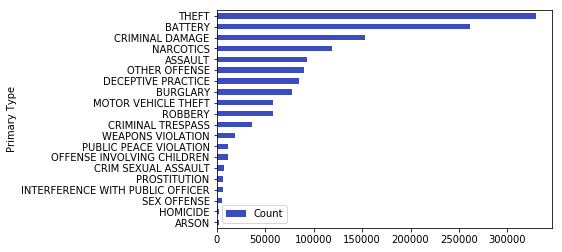

In [27]:
sort_crime_count = pd.DataFrame(Temp_sub.groupby(['Primary Type']).agg({'Count': np.sum}))

sort_crime_count = sort_crime_count.sort_values(by = "Count", ascending = True).tail(20)

sort_crime_count.plot(kind = 'barh',colormap= 'coolwarm')


In [28]:
avg_crime_count_bymonth = pd.DataFrame(Temp_sub.groupby(['Primary Type','month']).agg({'Count': np.sum}))

avg_crime_count_bymonth.head()


#avg_crime_count_byyear = pd.DataFrame(Temp_sub.groupby(['Primary Type','month', 'year']).agg({'Count': np.sum}))
#avg_crime_count_byyear.head(10)

assault_bymonth = avg_crime_count_bymonth.loc['ASSAULT'] / 5

narcotics_bymonth = avg_crime_count_bymonth.loc['NARCOTICS'] / 5

crimesex_bymonth = avg_crime_count_bymonth.loc['CRIM SEXUAL ASSAULT'] / 5
battery_bymonth = avg_crime_count_bymonth.loc['BATTERY'] / 5
theft_bymonth = avg_crime_count_bymonth.loc['THEFT'] / 5

### Mean temperature by month across 2013-2017
Temp_bymonth = Temp_sub.groupby('month').agg({'Temperature':np.mean})
Temp_bymonth


,Temperature
month,
1,-3.341509
2,-3.588281
3,1.982528
4,9.091234
5,14.866458
6,19.958908
7,22.574692
8,22.151078
9,19.674832


In [29]:
Temp_sub['Temprange'] = Temp_sub.apply(vectorize_temperature, axis=1)

Temp_sub3 = pd.DataFrame(Temp_sub.groupby(['Primary Type','Temprange']).agg({'Count': np.sum}))

asc_temp_sub3 = Temp_sub3.sort_values(by = "Count", ascending = 0)

asc_temp_sub3


Count
Primary Type                      Temprange       
THEFT                             0-5        95265
BATTERY                           0-5        73756
THEFT                             20-25      69308
                                  15-20      58250
BATTERY                           20-25      56699
THEFT                             5-10       51227
BATTERY                           15-20      45670
CRIMINAL DAMAGE                   0-5        43691
BATTERY                           5-10       40803
NARCOTICS                         0-5        40048
THEFT                             10-15      39978
BATTERY                           10-15      31929
CRIMINAL DAMAGE                   20-25      31867
OTHER OFFENSE                     0-5        28181
DECEPTIVE PRACTICE                0-5        27611
CRIMINAL DAMAGE                   15-20      26645
ASSAULT                           0-5        25678
CRIMINAL DAMAGE                   5-10       25288
BURGLARY                          0-5        23770
NARCOTICS                         20-25      21434
ASSAULT                           20-25      20069
MOTOR VEHICLE THEFT               0-5        19510
NARCOTICS                         15-20      19347
                                  5-10       19141
CRIMINAL DAMAGE                   10-15      19086
OTHER OFFENSE                     20-25      17629
ROBBERY                           0-5        17442
ASSAULT                           15-20      16824
DECEPTIVE PRACTICE                20-25      16177
BURGLARY                          20-25      15146
...                                            ...
PUBLIC INDECENCY                  5-10          10
CONCEALED CARRY LICENSE VIOLATION 25-30          9
NON - CRIMINAL                    20-25          9
                                  0-5            8
HUMAN TRAFFICKING                 20-25          8
                                  0-5            8
                                  15-20          7
CRIM SEXUAL ASSAULT               >30            6
HUMAN TRAFFICKING                 5-10           6
OFFENSE INVOLVING CHILDREN        >30            6
OTHER NARCOTIC VIOLATION          15-20          6
NON - CRIMINAL                    10-15          6
NON-CRIMINAL (SUBJECT SPECIFIED)  0-5            5
OTHER NARCOTIC VIOLATION          5-10           5
PUBLIC INDECENCY                  10-15          4
HUMAN TRAFFICKING                 10-15          4
                                  25-30          4
INTERFERENCE WITH PUBLIC OFFICER  >30            4
PROSTITUTION                      >30            4
NON-CRIMINAL                      25-30          4
SEX OFFENSE                       >30            3
GAMBLING                          >30            3
PUBLIC INDECENCY                  25-30          3
WEAPONS VIOLATION                 >30            3
OTHER NARCOTIC VIOLATION          25-30          2
                                  10-15          2
ARSON                             >30            2
NON - CRIMINAL                    5-10           2
HOMICIDE                          >30            1
INTIMIDATION                      >30            1

[214 rows x 1 columns]

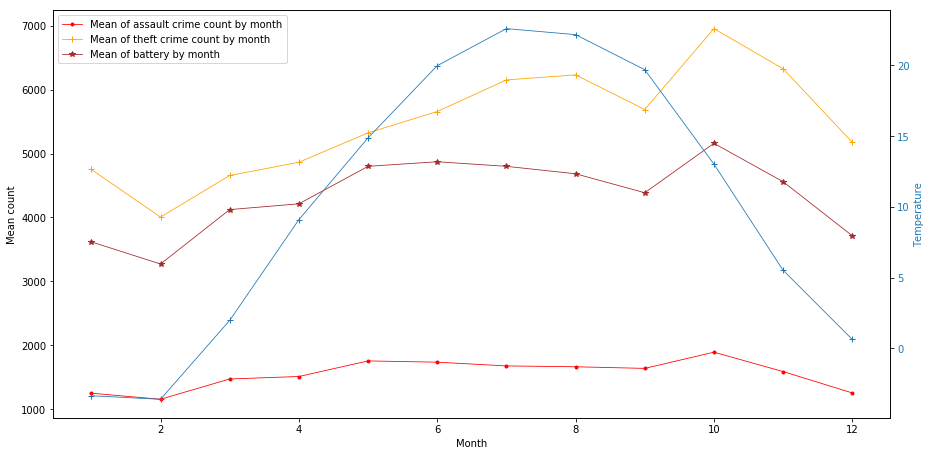

In [30]:
fig, ax1 = plt.subplots(figsize = (15,7.5))

ax1.plot(assault_bymonth , linewidth = 0.8, marker = '.', label = "Mean of assault crime count by month", color='Red')
ax1.plot(theft_bymonth, linewidth = 0.8, marker = '+', label = "Mean of theft crime count by month", color='Orange')
ax1.plot(battery_bymonth, linewidth = 0.8, marker = '*', label = "Mean of battery by month", color='Brown')

ax1.set_xlabel("Month") 
ax1.set_ylabel("Mean count") 
ax1.tick_params(axis='y')
ax1.legend()



ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Temperature', color=color)  # we already handled the x-label with ax1
ax2.plot(Temp_bymonth, linewidth = 0.8, marker = '+', label = "Mean of narcotics crime count by month", color='tab:blue')
ax2.tick_params(axis='y', labelcolor=color)




plt.show()

Describe the plot here 

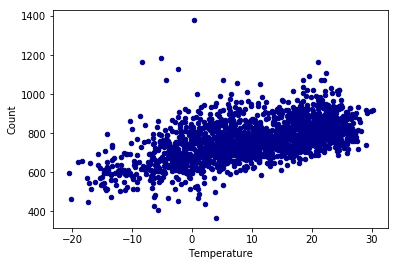

In [31]:
Temp_sub1 = pd.DataFrame(Temp_sub.groupby(['year','month','day']).agg({'Count': np.sum, 'Temperature': np.mean}))
Temp_sub1 = Temp_sub1.reset_index()

ax1 = Temp_sub1.plot.scatter(x='Temperature',y = 'Count',c = 'DarkBlue')
plt.show()

In [32]:

chicago_linear_model = ols("Count ~ Temperature", data=Temp_sub1).fit()
chicago_linear_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     812.3
Date:                Fri, 03 May 2019   Prob (F-statistic):          7.64e-149
Time:                        11:26:04   Log-Likelihood:                -11059.
No. Observations:                1885   AIC:                         2.212e+04
Df Residuals:                    1883   BIC:                         2.213e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     709.6562      2.740    258.960      0.000     704.282     715.031
Temperature     5.3223      0.187     28.500      0.000       4.956       5.689
==============================================================================
Omnibus:                      400.875   Durbin-Watson:                   0.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1579.961
Skew:                           0.987   Prob(JB):                         0.00
Kurtosis:                       7.027   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

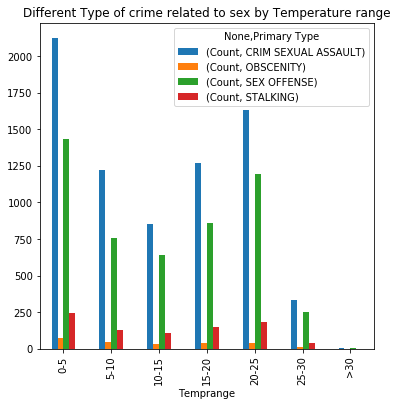

In [33]:
Temp_sub['Temprange'] = Temp_sub.apply(vectorize_temperature, axis=1)

Temp_sub.head()

Temp_sexual3 = Temp_sub.loc[Temp_sub['Primary Type'].isin(['CRIM SEXUAL ASSAULT','OBSCENITY', 'SEX OFFENSE','STALKING'])]

Temp_sub3 =Temp_sexual3.groupby(['Temprange','Primary Type']).agg({'Count': np.sum}).unstack()

Temp_sub3 = Temp_sub3.reindex(index = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '>30'])


Temp_sub3
Temp_sub3.plot(kind = 'bar', title = "Different Type of crime related to sex by Temperature range", figsize=(6,6))
plt.xticks(rotation=90)



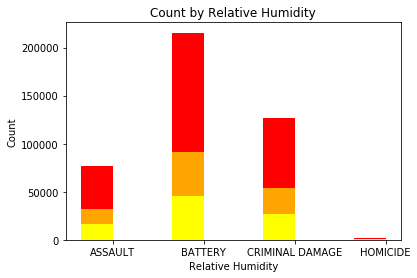

In [34]:
crime_count = crime_count_total.loc[crime_count_total['Primary Type'].isin(['ASSAULT','BATTERY', 'CRIMINAL DAMAGE','HOMICIDE'])]
fig, ax = plt.subplots()
N = len(set(crime_count['Primary Type']))
HighCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'High', 'Count'])
NormalCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'Normal', 'Count'])
LowCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'Low', 'Count'])
ind = np.arange(N)
width = 0.35

p1 = ax.bar(ind, LowCounts, width,color='Yellow')
p2 = ax.bar(ind, NormalCounts, width, color='Orange', bottom = LowCounts)
p3 = ax.bar(ind, HighCounts, width, color = 'Red', bottom = NormalCounts)
ax.set_ylabel('Count')
ax.set_xlabel('Relative Humidity')
ax.set_title('Count by Relative Humidity')
ax.set_xticks(ind + width / 2.)
#ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('ASSAULT','BATTERY', 'CRIMINAL DAMAGE','HOMICIDE'))
plt.show()

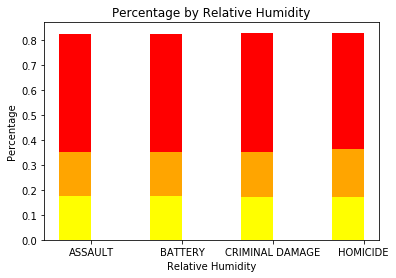

In [35]:
fig, ax = plt.subplots()
N = len(set(crime_count['Primary Type']))
HighCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'High', 'Count'])
NormalCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'Normal', 'Count'])
LowCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'Low', 'Count'])
totalCounts = list(map(sum, zip(HighCounts,NormalCounts,LowCounts)))


Highpercent = [x/y for x, y in zip(HighCounts, totalCounts)]
Normalpercent = [x/y for x, y in zip(NormalCounts, totalCounts)]
Lowpercent = [x/y for x, y in zip(LowCounts, totalCounts)]
ind = np.arange(N)
width = 0.35

p1 = ax.bar(ind, Lowpercent, width,color='Yellow')
p2 = ax.bar(ind, Normalpercent, width, color='Orange', bottom = Lowpercent)
p3 = ax.bar(ind, Highpercent, width, color = 'Red', bottom = Normalpercent)
ax.set_ylabel('Percentage')
ax.set_xlabel('Relative Humidity')
ax.set_title('Percentage by Relative Humidity')
ax.set_xticks(ind + width / 2.)
#ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('ASSAULT','BATTERY', 'CRIMINAL DAMAGE','HOMICIDE'))
plt.show()

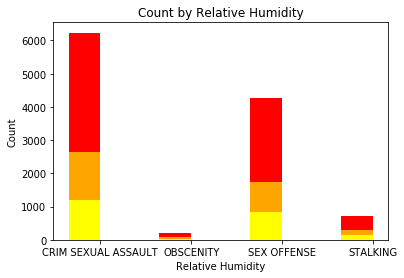

In [36]:
crime_count = crime_count_total.loc[crime_count_total['Primary Type'].isin(['CRIM SEXUAL ASSAULT','OBSCENITY', 'SEX OFFENSE','STALKING'])]
fig, ax = plt.subplots()
N = len(set(crime_count['Primary Type']))
HighCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'High', 'Count'])
NormalCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'Normal', 'Count'])
LowCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'Low', 'Count'])
ind = np.arange(N)
width = 0.35

p1 = ax.bar(ind, LowCounts, width,color='Yellow')
p2 = ax.bar(ind, NormalCounts, width, color='Orange', bottom = LowCounts)
p3 = ax.bar(ind, HighCounts, width, color = 'Red', bottom = NormalCounts)
ax.set_ylabel('Count')
ax.set_xlabel('Relative Humidity')
ax.set_title('Count by Relative Humidity')
ax.set_xticks(ind + width / 2.)
ax.set_xticklabels(('CRIM SEXUAL ASSAULT','OBSCENITY', 'SEX OFFENSE','STALKING'))
plt.show()

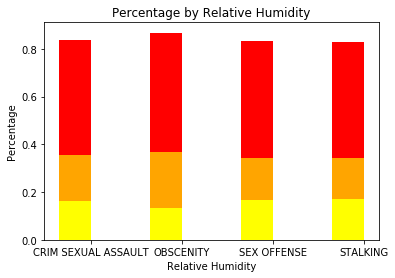

In [37]:
fig, ax = plt.subplots()
N = len(set(crime_count['Primary Type']))
HighCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'High', 'Count'])
NormalCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'Normal', 'Count'])
LowCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'Low', 'Count'])
totalCounts = list(map(sum, zip(HighCounts,NormalCounts,LowCounts)))


Highpercent = [x/y for x, y in zip(HighCounts, totalCounts)]
Normalpercent = [x/y for x, y in zip(NormalCounts, totalCounts)]
Lowpercent = [x/y for x, y in zip(LowCounts, totalCounts)]
ind = np.arange(N)
width = 0.35

p1 = ax.bar(ind, Lowpercent, width,color='Yellow')
p2 = ax.bar(ind, Normalpercent, width, color='Orange', bottom = Lowpercent)
p3 = ax.bar(ind, Highpercent, width, color = 'Red', bottom = Normalpercent)
ax.set_ylabel('Percentage')
ax.set_xlabel('Relative Humidity')
ax.set_title('Percentage by Relative Humidity')
ax.set_xticks(ind + width / 2.)
#ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('CRIM SEXUAL ASSAULT','OBSCENITY', 'SEX OFFENSE','STALKING'))
plt.show()

# LA

## 1. Temperature's effect on crime in LA

In [38]:
LA_crime = read_indata('./LA_Crime_Data_2010_to_Present.csv')
LA_crime.head(10)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
0,61000673,04/07/2016,04/07/2016,2043,10,West Valley,1037,886,DISTURBING THE PEACE,1501,...,NaN,IC,Invest Cont,886.0,NaN,NaN,NaN,17100 VANOWEN ST,NaN,"(34.1939, -118.5055)"
1,131609876,04/02/2016,04/01/2016,1900,19,Mission,1902,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),NaN,...,NaN,IC,Invest Cont,420.0,NaN,NaN,NaN,13600 DRONEFIELD AV,NaN,"(34.3196, -118.4561)"
2,150319258,08/20/2016,08/20/2016,30,3,Southwest,325,440,THEFT PLAIN - PETTY ($950 & UNDER),0344,...,NaN,AO,Adult Other,440.0,NaN,NaN,NaN,2800 MENLO AV,NaN,"(34.0294, -118.2903)"
3,151601466,01/01/2016,01/01/2016,2040,16,Foothill,1642,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0334 0411 1402,...,OTHER KNIFE,AA,Adult Arrest,230.0,998.0,NaN,NaN,10500 CAYUGA AV,NaN,"(34.2606, -118.4238)"
4,151601467,01/02/2016,01/02/2016,30,16,Foothill,1668,624,BATTERY - SIMPLE ASSAULT,0416,...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,624.0,NaN,NaN,NaN,9800 MARCUS AV,NaN,"(34.2463, -118.2818)"
5,151801503,01/01/2016,01/01/2016,320,18,Southeast,1838,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0411,...,UNKNOWN TYPE CUTTING INSTRUMENT,IC,Invest Cont,230.0,NaN,NaN,NaN,10300 HICKORY ST,NaN,"(33.9431, -118.2358)"
6,160100501,01/02/2016,01/01/2016,2230,1,Central,152,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),0344 1402,...,NaN,IC,Invest Cont,420.0,998.0,NaN,NaN,WILSHIRE BL,HOPE ST,"(34.0487, -118.2571)"
7,160100503,01/01/2016,01/01/2016,1600,1,Central,185,625,OTHER ASSAULT,1212 0305 0432,...,NaN,AO,Adult Other,625.0,NaN,NaN,NaN,OLYMPIC BL,MAPLE ST,"(34.0383, -118.254)"
8,160100504,01/01/2016,01/01/2016,2215,1,Central,138,626,INTIMATE PARTNER - SIMPLE ASSAULT,0444 2000 0416 1814 0432 0334,...,NaN,AA,Adult Arrest,626.0,NaN,NaN,NaN,200 S SAN PEDRO ST,NaN,"(34.0493, -118.2418)"
9,160100505,01/02/2016,01/02/2016,45,1,Central,162,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 2004,...,NaN,IC,Invest Cont,745.0,NaN,NaN,NaN,800 S FIGUEROA ST,NaN,"(34.0479, -118.2612)"


In [39]:
LA_crime['year'] = LA_crime['Date Occurred'].str[6:10].astype(int)
LA_crime['month'] = LA_crime['Date Occurred'].str[0:2].astype(int)
LA_crime['day'] = LA_crime['Date Occurred'].str[3:5].astype(int)

In [40]:
LA_crime.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location,year,month,day
0,61000673,04/07/2016,04/07/2016,2043,10,West Valley,1037,886,DISTURBING THE PEACE,1501,...,886.0,NaN,NaN,NaN,17100 VANOWEN ST,NaN,"(34.1939, -118.5055)",2016,4,7
1,131609876,04/02/2016,04/01/2016,1900,19,Mission,1902,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),NaN,...,420.0,NaN,NaN,NaN,13600 DRONEFIELD AV,NaN,"(34.3196, -118.4561)",2016,4,1
2,150319258,08/20/2016,08/20/2016,30,3,Southwest,325,440,THEFT PLAIN - PETTY ($950 & UNDER),0344,...,440.0,NaN,NaN,NaN,2800 MENLO AV,NaN,"(34.0294, -118.2903)",2016,8,20
3,151601466,01/01/2016,01/01/2016,2040,16,Foothill,1642,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0334 0411 1402,...,230.0,998.0,NaN,NaN,10500 CAYUGA AV,NaN,"(34.2606, -118.4238)",2016,1,1
4,151601467,01/02/2016,01/02/2016,30,16,Foothill,1668,624,BATTERY - SIMPLE ASSAULT,0416,...,624.0,NaN,NaN,NaN,9800 MARCUS AV,NaN,"(34.2463, -118.2818)",2016,1,2


In [41]:
LA_crime = LA_crime[(LA_crime.year>=2012) & (LA_crime.year<2018)]
#LA_crime_per_day = LA_crime[['year','month','day','DR Number','Crime Code Description']].groupby(['year', 'month', 'day', 'Crime Code Description']).count().reset_index().rename(columns={'DR Number':'count'})
LA_crime_per_day = LA_crime[['year','month','day','DR Number']].groupby(['year', 'month', 'day']).count().reset_index().rename(columns={'DR Number':'count'})
LA_crime_per_day.head()

,year,month,day,count
0,2012,1,1,1742
1,2012,1,2,476
2,2012,1,3,554
3,2012,1,4,530
4,2012,1,5,519


In [42]:
LA_temp=Temperature[['Los Angeles','year','month','day']]
LA_temp['Los Angeles']=LA_temp['Los Angeles']-273.5
LA_temp.head()

C:\Program Files\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Los Angeles,year,month,day
0,NaN,2012,10,1
1,18.370000,2012,10,1
2,18.368186,2012,10,1
3,18.362844,2012,10,1
4,18.357503,2012,10,1


In [43]:
LA_temp_avg_month=LA_temp[['Los Angeles','year','month']].groupby(['year','month'], as_index=False ).agg({'mean'}).reset_index().rename(columns={'Los Angeles':'mean_temp'})
LA_temp_avg_month.columns = LA_temp_avg_month.columns.droplevel(1)
LA_temp_avg_month.head()

,year,month,mean_temp
0,2012,10,19.755154
1,2012,11,15.776347
2,2012,12,12.739209
3,2013,1,11.242942
4,2013,2,12.234333


In [44]:
LA_crime_year_month=LA_crime[['year','month','DR Number']].groupby(['year', 'month']).count().reset_index().rename(columns={'DR Number':'count'})
LA_crime_year_month.head()

,year,month,count
0,2012,1,17745
1,2012,2,15316
2,2012,3,16562
3,2012,4,16275
4,2012,5,17466


In [45]:
LA_crime_weather_month= merge_dataframe(LA_crime_year_month,LA_temp_avg_month,['year', 'month'])
LA_crime_weather_month=LA_crime_weather_month.dropna()
#LA_crime_weather_month['year_month']=LA_crime_weather_month.apply(lambda row: datetime(row['year'], row['month']), axis=1)
LA_crime_weather_month['year_month']=LA_crime_weather_month['year'].astype(str)+'-'+LA_crime_weather_month['month'].astype(str)
#LA_crime_weather_month['year_month']=LA_crime_weather_month.apply(lambda x: 100*x.year + x.month)
LA_crime_weather_month.head()

,year,month,count,mean_temp,year_month
9,2012,10,17207,19.755154,2012-10
10,2012,11,15750,15.776347,2012-11
11,2012,12,16270,12.739209,2012-12
12,2013,1,16623,11.242942,2013-1
13,2013,2,14037,12.234333,2013-2


Compare the line plot of monthly crime numbers and monthly average temperature. The x-axis represents the month and year, the left y-axis represents the total crime number in that month, the right y-axis represents the average temperature in that month. From the plot we can see the fluctuation of the crime count and the temperature are parellel in some parts, so we assume there might be some connections betweeen the crime count and the temperature in LA. While from the line plot we can't see the connection very clearly, we need a futher analysis.  

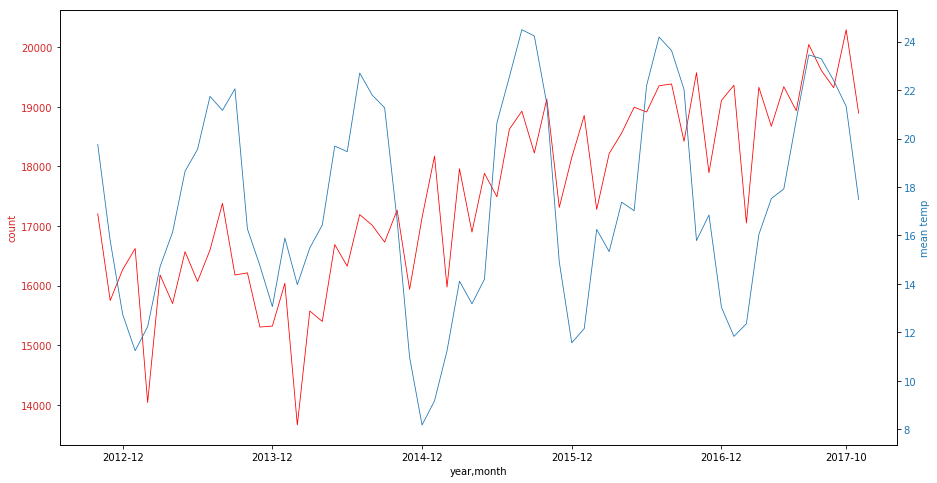

In [46]:
fig, ax1 = plt.subplots(figsize = (15,8))
color = 'tab:red'
ax1.set_xlabel('year,month')
ax1.set_ylabel('count', color=color)
ax1.plot(LA_crime_weather_month['year_month'], LA_crime_weather_month['count'], linewidth = 0.8,label = "Monthly crime count", color='Red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('mean temp', color=color)  
ax2.plot(LA_crime_weather_month['year_month'], LA_crime_weather_month['mean_temp'],linewidth = 0.8,label = "Monthly average temperature",color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks(['2012-12','2013-12','2014-12','2015-12','2016-12','2017-10'])
plt.show()


In [47]:
LA_temp_avg_day=LA_temp[['Los Angeles','year','month','day']].groupby(['year','month','day'], as_index=False ).agg({'mean'}).reset_index().rename(columns={'Los Angeles':'mean_temp'})
LA_temp_avg_day.columns = LA_temp_avg_day.columns.droplevel(1)
LA_temp_avg_day.head()

,year,month,day,mean_temp
0,2012,10,1,18.346501
1,2012,10,2,22.390450
2,2012,10,3,25.508542
3,2012,10,4,22.497917
4,2012,10,5,19.448333


In [48]:
LA_crime_weather_day=pd.merge(LA_crime_per_day, LA_temp_avg_day,on=['year', 'month','day'])
LA_crime_weather_day.head()

,year,month,day,count,mean_temp
0,2012,10,1,872,18.346501
1,2012,10,2,547,22.390450
2,2012,10,3,546,25.508542
3,2012,10,4,498,22.497917
4,2012,10,5,625,19.448333


The scatter plot of the daily crime count and the daily temperature

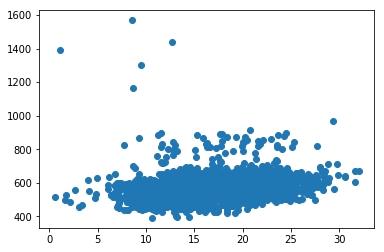

In [49]:
LA_crime_weather_day.corr() 
plt.scatter(LA_crime_weather_day['mean_temp'], LA_crime_weather_day['count'])

Apply a linear analysis on the daily crime count and daily temperature between 2010-10 to 2017-10.

In [50]:
LA_temp_linear_model = ols("count ~ mean_temp", data=LA_crime_weather_day).fit()
LA_temp_linear_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     63.58
Date:                Fri, 03 May 2019   Prob (F-statistic):           2.64e-15
Time:                        11:26:15   Log-Likelihood:                -11037.
No. Observations:                1887   AIC:                         2.208e+04
Df Residuals:                    1885   BIC:                         2.209e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    521.9858      7.023     74.326      0.000     508.212     535.759
mean_temp      3.1033      0.389      7.974      0.000       2.340       3.867
==============================================================================
Omnibus:                     1543.782   Durbin-Watson:                   1.481
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72245.636
Skew:                           3.494   Prob(JB):                         0.00
Kurtosis:                      32.497   Cond. No.                         65.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2.Temperature's effect on different kind of crimes in LA 

In [51]:
LA_crime_type=LA_crime[['Crime Code Description','DR Number']].groupby(['Crime Code Description']).count().reset_index().rename(columns={'DR Number':'count'})
LA_crime_type.sort_values(by = "count", ascending = 0).head()

,Crime Code Description,count
5,BATTERY - SIMPLE ASSAULT,111768
133,VEHICLE - STOLEN,95625
22,BURGLARY FROM VEHICLE,93801
116,THEFT PLAIN - PETTY ($950 & UNDER),93234
21,BURGLARY,88167


In [52]:
LA_crime_type['Crime Code Description'].count()
LA_crime_type['Crime Code Description'][1]
if 'A' in LA_crime['Crime Code Description'][1]:
    LA_crime['Crime Code Description'][1]='A' 

In [53]:
def normalize_crime_type(df):
    """
    """
    index=df.index
    for i in index:
        if 'STOLEN' in df[i]:
            df[i]='STOLEN'
        elif 'THEFT' in df[i]:
            df[i]='THEFT'
        elif 'BATTERY' in df[i]:
            df[i]='BATTERY'
        elif 'ASSULT' in df[i]:
            df[i]='ASSULT'
        elif 'VANDALISM' in df[i]:
            df[i]='VANDALISM'
        elif 'VIOLATION' in df[i]:
            df[i]='VIOLATION'
        else:
            continue
    return df

In [54]:
LA_crime_type_monthly=LA_crime[['year','month','Crime Code Description','DR Number']].groupby(['year', 'month','Crime Code Description']).count().reset_index().rename(columns={'DR Number':'count'})
LA_crime_type_monthly.head()

,year,month,Crime Code Description,count
0,2012,1,ARSON,52
1,2012,1,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,21
2,2012,1,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",603
3,2012,1,ATTEMPTED ROBBERY,111
4,2012,1,BATTERY - SIMPLE ASSAULT,1495


## New York City 

## 1. Temperature's effect on crimes in New York City 

In [55]:
NY_crime=FUNC.read_indata('./NYPD_Complaint_Data_Historic.csv')
NY_crime.head()

C:\Program Files\Python37\lib\site-packages\IPython\core\interactiveshell.py:2809: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,789626784,04/24/2015,00:01:00,NaN,NaN,105.0,04/27/2015,578,HARRASSMENT 2,638.0,...,F,NaN,40.660029,-73.739577,"(40.660028593, -73.739576566)",PATROL BORO QUEENS SOUTH,NaN,25-44,BLACK,F
1,939665334,04/23/2015,22:00:00,04/23/2015,22:10:00,13.0,04/27/2015,109,GRAND LARCENY,418.0,...,NaN,NaN,40.733933,-73.977327,"(40.73393308, -73.977326958)",PATROL BORO MAN SOUTH,NaN,45-64,UNKNOWN,F
2,414873301,04/23/2015,21:35:00,04/24/2015,13:59:00,73.0,04/27/2015,109,GRAND LARCENY,422.0,...,NaN,NaN,40.673844,-73.916732,"(40.673844225, -73.916732256)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,F
3,879233701,04/23/2015,19:45:00,NaN,NaN,43.0,04/27/2015,341,PETIT LARCENY,338.0,...,U,NaN,40.823500,-73.858619,"(40.823499964, -73.858618987)",PATROL BORO BRONX,NaN,NaN,UNKNOWN,D
4,236156807,04/23/2015,19:21:00,04/25/2015,20:08:00,34.0,04/27/2015,126,MISCELLANEOUS PENAL LAW,198.0,...,M,NaN,40.851112,-73.935256,"(40.851111636, -73.935255912)",PATROL BORO MAN NORTH,NaN,25-44,BLACK,F


In [56]:
NY_monthly_crime=FUNC.crime_count(NY_crime, 'RPT_DT','month')
NY_monthly_crime.head()

count
year month       
2012 1      41569
     2      39248
     3      43539
     4      41721
     5      44949

In [57]:
NY_temp=FUNC.city_temp_Celsius(Temperature,'New York')
NY_temp.head()

C:\Users\yiwen\PycharmProjects\Final_Project\FUNC.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  city_temp[city]=city_temp[city]-273.5


,New York,year,month,day
0,NaN,2012,10,1
1,14.720000,2012,10,1
2,14.747676,2012,10,1
3,14.826940,2012,10,1
4,14.906203,2012,10,1


In [58]:
NY_monthly_avg_temp=FUNC.average_temp(NY_temp,'New York','month')
NY_monthly_avg_temp.head()

,year,month,mean_temp
0,2012,10,14.040227
1,2012,11,5.595819
2,2012,12,4.322878
3,2013,1,0.776306
4,2013,2,0.262894


In [59]:
NY_crime_weather_monthly= merge_dataframe(NY_monthly_crime,NY_monthly_avg_temp,['year', 'month'])
NY_crime_weather_monthly=NY_crime_weather_monthly.dropna()
NY_crime_weather_monthly.head()

,year,month,count,mean_temp
9,2012,10,41908,14.040227
10,2012,11,35491,5.595819
11,2012,12,38897,4.322878
12,2013,1,40357,0.776306
13,2013,2,35364,0.262894


In [60]:
NY_crime_weather_monthly['year_month']=NY_crime_weather_monthly['year'].astype(str)+'-'+NY_crime_weather_monthly['month'].astype(str)
NY_crime_weather_monthly.head()

,year,month,count,mean_temp,year_month
9,2012,10,41908,14.040227,2012-10
10,2012,11,35491,5.595819,2012-11
11,2012,12,38897,4.322878,2012-12
12,2013,1,40357,0.776306,2013-1
13,2013,2,35364,0.262894,2013-2


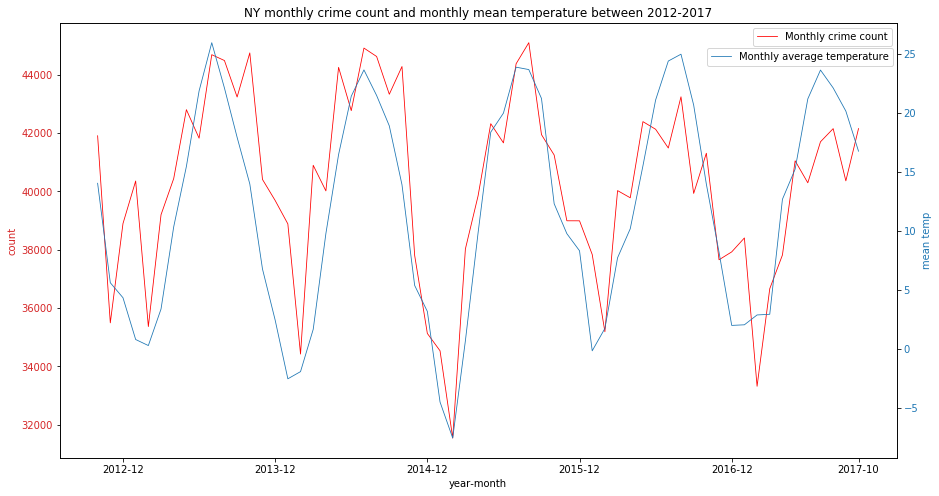

In [61]:
fig, ax1 = plt.subplots(figsize = (15,8))
color = 'tab:red'
ax1.set_xlabel('year-month')
ax1.set_ylabel('count', color=color)
ax1.plot(NY_crime_weather_monthly['year_month'], NY_crime_weather_monthly['count'], linewidth = 0.8,label = "Monthly crime count", color='Red')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('mean temp', color=color)  
ax2.plot(NY_crime_weather_monthly['year_month'], NY_crime_weather_monthly['mean_temp'],linewidth = 0.8,label = "Monthly average temperature",color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks(['2012-12','2013-12','2014-12','2015-12','2016-12','2017-10'])
plt.title('NY monthly crime count and monthly mean temperature between 2012-2017')
ax1.legend()
ax2.legend(bbox_to_anchor=(0.768,0.89))

plt.show()

In [62]:
NY_daily_crime=FUNC.crime_count(NY_crime, 'RPT_DT','day')
NY_daily_crime.head()

count
year month day       
2012 1     1     1312
           2     1085
           3     1318
           4     1276
           5     1425

In [63]:
NY_daily_temp=FUNC.average_temp(NY_temp,'New York','day')
NY_daily_temp.head()

,year,month,day,mean_temp
0,2012,10,1,15.069420
1,2012,10,2,17.392389
2,2012,10,3,16.565625
3,2012,10,4,18.487083
4,2012,10,5,20.543542


In [64]:
NY_crime_weather_day=pd.merge(NY_daily_crime, NY_daily_temp,on=['year', 'month','day'])
NY_crime_weather_day.head()

,year,month,day,count,mean_temp
0,2012,10,1,1327,15.069420
1,2012,10,2,1419,17.392389
2,2012,10,3,1553,16.565625
3,2012,10,4,1599,18.487083
4,2012,10,5,1601,20.543542


In [65]:
NY_crime_weather_day[['count','mean_temp']].corr() 

,count,mean_temp
count,1.000000,0.515759
mean_temp,0.515759,1.000000


Text(0, 0.5, 'daily crime')

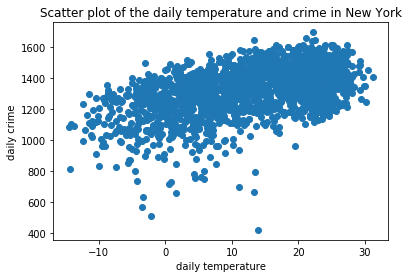

In [66]:
plt.scatter(NY_crime_weather_day['mean_temp'], NY_crime_weather_day['count'])
plt.title('Scatter plot of the daily temperature and crime in New York')
plt.xlabel('daily temperature')
plt.ylabel('daily crime')

In [67]:
NY_temp_linear_model = ols("count ~ mean_temp", data=NY_crime_weather_day).fit()
NY_temp_linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     671.2
Date:                Fri, 03 May 2019   Prob (F-statistic):          1.53e-126
Time:                        11:26:56   Log-Likelihood:                -11733.
No. Observations:                1854   AIC:                         2.347e+04
Df Residuals:                    1852   BIC:                         2.348e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1222.9794      4.978    245.666      0.000    1213.216    1232.743
mean_temp      8.3894      0.324     25.907      0.000       7.754       9.025
==============================================================================
Omnibus:                      332.624   Durbin-Watson:                   1.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              787.005
Skew:                          -0.993   Prob(JB):                    1.27e-171
Kurtosis:                       5.498   Cond. No.                         24.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""